# COVID19_Detection_Project
* Authors: Jihoon Chung, Kibae Kim

![COVID](images/COVID19.png)

## Overview


Using data pulled out from Kaggle, we retrieved chest X-Ray of normal people & COVID-19 patients:<br>
Data Imported from = https://www.kaggle.com/donjon00/covid19-detection <br>
    *NORMAL IMAGES = 11,767 Images<br>
    *COVID-19 IMAGES = 3,616 Images
***
Coronavirus disease 2019 (COVID-19) is a contagious disease caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). The disease has since spread worldwide, leading to an ongoing pandemic.
So, we built a deep learning model to detect people who infected to COVID-19 virus by using their lung X-ray data from Kaggle. This project will help hospitals figure out infected people when they don’t have COVID test kit.


## Business Problem

There are many hospitals running out of COVID test kits. Will they be able to detect COVID-19 positivity simply using the X-Ray images? We are looking to build a model to classify COVID-19 infection status simply with a X-ray image.

In [69]:
import pandas as pd
import numpy as np
import os
import sys

import pickle
from datetime import datetime


from scipy.stats import ttest_ind, mannwhitneyu


import tensorflow as tf
from math import ceil


# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from skimage.feature import hog
from skimage import data, exposure

# preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.image import rgb_to_grayscale
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input


# Reshaping 
from tensorflow import reshape
from tensorflow.image import resize_with_pad
from keras.layers import Concatenate
from tensorflow.keras.utils import to_categorical

# Modelling 
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD

# Transfer learning
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.applications import MobileNetV2

# metrics
from tensorflow.keras.metrics import Recall, AUC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, recall_score, roc_curve, auc, classification_report
from sklearn.decomposition import PCA

%matplotlib inline



# module_path = os.path.abspath(os.path.join('src'))
# if module_path not in sys.path:
#     sys.path.append(module_path)
# # Custom modules 
# from modules import data, graphs, eda
plt.style.use('ggplot')
np.random.seed(42)

## 1. Data Understanding

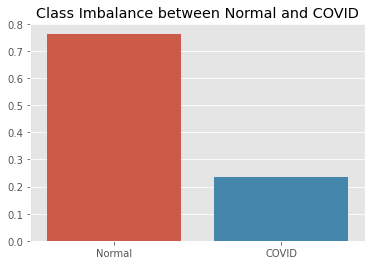

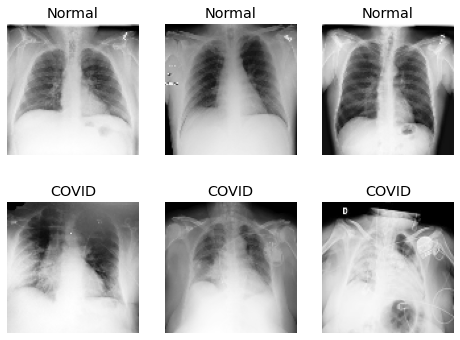

In [2]:
train_dir = './data/train'

# get the list of images from sub image class folders
normal_imgs = [fn for fn in os.listdir(f'{train_dir}/Normal')]
covid_imgs = [fn for fn in os.listdir(f'{train_dir}/COVID')]

# select 3 images of each normal and covid randomly
select_norm = np.random.choice(normal_imgs, 3, replace = False)
select_covid = np.random.choice(covid_imgs, 3, replace = False)

# calculate class imbalance between normal and covid images
normal_size = len(normal_imgs)/(len(normal_imgs)+len(covid_imgs))
covid_size = len(covid_imgs)/(len(normal_imgs)+len(covid_imgs))

ax = sns.barplot(x = ['Normal', 'COVID'],
                 y = [normal_size, covid_size]);
ax.set_title("Class Imbalance between Normal and COVID");
plt.savefig("./images/classimbalance_Normal_COVID.png" ,bbox_inches='tight')

# plotting 3 of each normal and covid images
fig = plt.figure(figsize = (8,6))
for i in range(6):
    if i < 3:
        fp = f'{train_dir}/Normal/{select_norm[i]}'
        label = 'Normal'
    else:
        fp = f'{train_dir}/COVID/{select_covid[i-3]}'
        label = 'COVID'
    ax = fig.add_subplot(2, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (100,100), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.savefig("./images/norm_covid.png" ,bbox_inches='tight')    
plt.show()

Dataset is imbalanced. There are about x3 more normal datasets than the ones with COVID.

In [3]:
CATEGORIES = ['COVID', 'Normal']
data_dir = './data'

In [4]:
train_data_dir = './data/train'

# get the list of images from sub image class folders
train_normal_imgs = [fn for fn in os.listdir(f'{train_data_dir}/Normal')]
train_covid_imgs = [fn for fn in os.listdir(f'{train_data_dir}/COVID')]

print('There are', len(train_normal_imgs), 'normal Training images')
print('There are', len(train_covid_imgs), 'COVID Training images')

There are 9367 normal Training images
There are 2896 COVID Training images


In [5]:
test_data_dir = './data/test'
# get the list of images from sub image class folders
test_normal_imgs = [fn for fn in os.listdir(f'{test_data_dir}/Normal')]
test_covid_imgs = [fn for fn in os.listdir(f'{test_data_dir}/COVID')]
print('There are', len(test_normal_imgs), 'Normal Test images')
print('There are', len(test_covid_imgs), 'COVID Test images')

There are 1200 Normal Test images
There are 360 COVID Test images


In [6]:
valid_data_dir = './data/validation'
# get the list of images from sub image class folders
valid_normal_imgs = [fn for fn in os.listdir(f'{valid_data_dir}/Normal')]
valid_covid_imgs = [fn for fn in os.listdir(f'{valid_data_dir}/COVID')]
print('There are', len(valid_normal_imgs), 'Normal validation images')
print('There are', len(valid_covid_imgs), 'COVID validation images')

There are 1200 Normal validation images
There are 360 COVID validation images


In [7]:
def image_to_matrix(path, list_of_filename, size = (66,66)):
  
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

In [8]:
normal_images = image_to_matrix(f'{train_dir}/Normal/', normal_imgs)
covid_images = image_to_matrix(f'{train_dir}/COVID/', covid_imgs)

In [9]:
def find_mean_img(full_mat, title, size = (66,66), save_img=False, img_dir=None):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0) 
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.savefig(f"./images/average_{full_mat}.png" ,bbox_inches='tight')
    plt.show()
    return mean_img

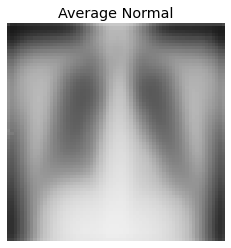

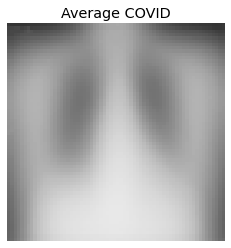

In [10]:
norm_mean = find_mean_img(normal_images, 'Normal')
covid_mean = find_mean_img(covid_images, 'COVID')

Comparison of Average Normal X-ray Picture vs Average COVID X-ray picture. <br>
Average Normal X-ray shows a lot more vacancy in the chest area.

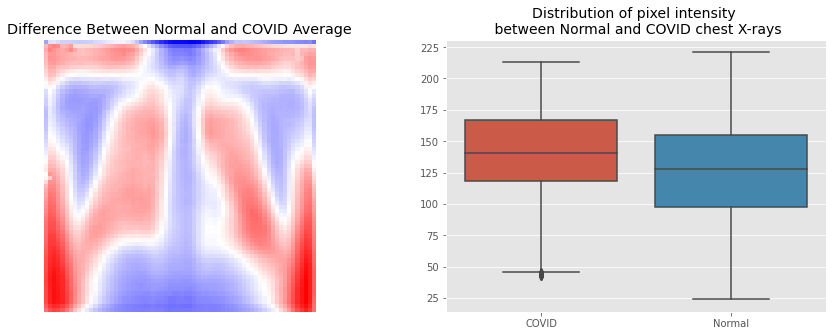

In [11]:
contrast_mean = covid_mean - norm_mean


fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15, 5))

ax[0].imshow(contrast_mean, cmap='bwr')
ax[0].set_title('Difference Between Normal and COVID Average')
ax[0].axis('off')

# flatten matrices
covid_mean_arr = covid_mean.ravel()
norm_mean_arr = norm_mean.ravel()


sick_healthy = pd.DataFrame([(covid_mean_arr),(norm_mean_arr)]).T
sick_healthy.columns = ['COVID', 'Normal']


sns.boxplot(data=sick_healthy, ax=ax[1]);
plt.title("Distribution of pixel intensity \n between Normal and COVID chest X-rays", size=14);

More red the area, more the difference in the average image.

## 2. Models

### 2.1 Baseline CNN Model

In [12]:
def import_image(PATH, image_name):
    """
    PATH --> str: Relative path to image directoy
    image_name --> str: Name of the image to load
    
    Returns:
    PIL image
    
    """
    
    # create path to file
    img_path = PATH + "/" + image_name
    
    # load file and return pil
    return image.load_img(img_path) 

def grayscale_and_resize(PIL, shape=(64,64), padding=False, grayscale=True):
    """
    This is the preprocessing function that will take the raw jpeg, gray scale it, resize it and 
    turn it into an array
    
    
    PIL --> PIL object
    shape --> tuple: size of the final array
    padding --> bool: if True, will use tf.resize_with_pad
    """
    if padding:
        gray_image = rgb_to_grayscale(PIL)
        resized_image_arr = resize_with_pad(gray_image, target_height=shape[0], target_width=shape[1])
    else:
        if grayscale:
            resized_image_arr = img_to_array(PIL.convert(mode = 'L').resize(shape))
        else:
            resized_image_arr = img_to_array(PIL.resize(shape))
    
    return resized_image_arr

def import_image_to_array(
         RELPATH,
         dir_names = ['train', 'test', 'validation'],
         sub_dir_names = ['Normal', 'COVID'],
         padding=False,
         shape=(64,64),
         grayscale=True,
         test=False
):

    # test relative path works!! 
    PATH = os.getcwd() + RELPATH
    
    try:
        os.listdir(PATH)
        print("Your relative directory is good, proceeding to import files...", end="\n\n")
    except Exception as e:
        print(str(e))
        print(f"Your relative path directory is not pointing to the correct location. Double check your input \n")
        print("Terminating Program", end='\n')
        print("=======================================================================================")
        return False
    
    
    # instantiate a dict object and populate the keys
    image_dict = {}
    for name in dir_names:
        image_dict[name] = []
        
        print(f"Loading images from {name}", end='\n')
        
        
        # For each subdirectory, get all of the images and append to dictionary
        for sub_dir in sub_dir_names:
            subPATH = PATH + name + "/" + sub_dir
            # list of all image names in the subdirectory
            image_batch = os.listdir(subPATH)
            
            for image in image_batch:
                # import the image in pil format
                pil = import_image(subPATH, image)
                # gray scale and reshape the image turning it into an array
                gray_resized_pil = grayscale_and_resize(pil, shape=shape, padding=padding, grayscale=grayscale)
                
                # center the pixels
                centered_array = gray_resized_pil/255
                
                # append to the image_dict with class flag
                flag = 1
                if sub_dir == 'Normal':
                    flag = 0
                
                image_dict[name].append((image, centered_array, flag))
                
            
                # if this is just a test case, break out of this loop so we get one from each class
                if test == True:
                    break
            
            print(f"Finished loading images from {sub_dir}", end="\n")

        print()
    
    return image_dict

In [13]:
images = import_image_to_array('/data/',
         dir_names = ['train', 'test', 'validation'],
         sub_dir_names = ['Normal', 'COVID'],
         padding=False,
         shape=(64,64), test=False, grayscale = False)

Your relative directory is good, proceeding to import files...

Loading images from train
Finished loading images from Normal
Finished loading images from COVID

Loading images from test
Finished loading images from Normal
Finished loading images from COVID

Loading images from validation
Finished loading images from Normal
Finished loading images from COVID



In [14]:
X_train = np.array([i[1] for i in images['train']])  
y_train = np.array([i[2] for i in images['train']])

X_test = np.array([i[1] for i in images['test']])
y_test = np.array([i[2] for i in images['test']])

X_val = np.array([i[1] for i in images['validation']])
y_val = np.array([i[2] for i in images['validation']])

In [15]:
#baseline model- two convolution layers, maxpooling, one 32 node dense layer and the output

cnn = models.Sequential()

# Input convolution layer
cnn.add(layers.Conv2D(64, kernel_size= (3, 3), activation='relu', input_shape=(64, 64,  3)))

# Max pooling layer
cnn.add(layers.MaxPooling2D((2, 2)))

# Hidden convolution layer and pool
cnn.add(layers.Conv2D(32, kernel_size= (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))

# Output
cnn.add(layers.Dense(1, activation='sigmoid'))

# Compiling with stochastic gradient descent, optimized for accuracy
cnn.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [16]:
cnn1 = cnn.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=50,
                    validation_data=(X_val, y_val))

Epoch 1/5
246/246 [==============================] - 13s 50ms/step - loss: 0.5737 - acc: 0.7327 - val_loss: 0.5097 - val_acc: 0.7686
Epoch 2/5
246/246 [==============================] - 12s 47ms/step - loss: 0.4772 - acc: 0.7791 - val_loss: 0.7695 - val_acc: 0.5372
Epoch 3/5
246/246 [==============================] - 12s 47ms/step - loss: 0.4387 - acc: 0.7991 - val_loss: 0.5265 - val_acc: 0.7686
Epoch 4/5
246/246 [==============================] - 12s 47ms/step - loss: 0.4109 - acc: 0.8105 - val_loss: 0.5671 - val_acc: 0.7673
Epoch 5/5
246/246 [==============================] - 12s 47ms/step - loss: 0.3947 - acc: 0.8235 - val_loss: 0.5691 - val_acc: 0.7673


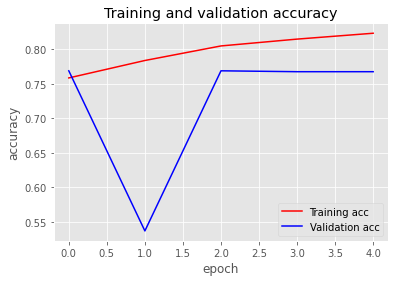

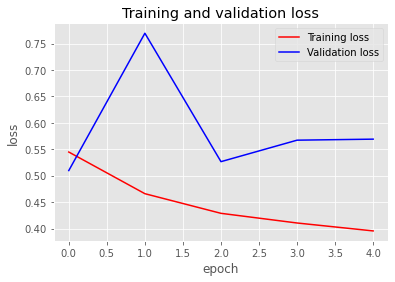

In [17]:
#Graphing our training and validation
acc = cnn1.history['acc']
val_acc = cnn1.history['val_acc']
loss = cnn1.history['loss']
val_loss = cnn1.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.savefig(f"./images/CNN_acc_loss.png" ,bbox_inches='tight')
plt.show()

In [18]:
results_test = cnn.evaluate(X_test, y_test)

49/49 [==============================] - 1s 10ms/step - loss: 0.5472 - acc: 0.7750


In [61]:
def get_labels(fit_model, X, threshold):
    return [1 if x >= threshold else 0 for x in fit_model.predict(X)]
def plot_cmatrix(model_name, actual, predictions):
    cmatrix = confusion_matrix(actual, predictions)
    fig, ax = plt.subplots(figsize = (12,6))
    sns.heatmap(cmatrix, annot=True, fmt='g', ax=ax, cmap='Blues')
    ax.set_xticklabels(['Normal', 'COVID'])
    ax.set_yticklabels(['Normal', 'COVID'])
    ax.set_ylabel('Actual', size=15)
    ax.set_xlabel('Predicted', size=15)
    ax.set_title(f'Confusion Matrix for {model_name} Predictions', size =18)
    plt.savefig(f"./images/{model_name}_confusion_matrix.png" ,bbox_inches='tight')
    return plt.show()

def plot_roc_curve(model_name, actual, predictions):
    '''Takes in arrays of actual binary values and model predictions and generates and plots an ROC curve'''
    fpr, tpr, threshholds = roc_curve(actual, predictions)
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC: {}'.format(round(auc(fpr, tpr),2)))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate', size=15)
    plt.ylabel('True Positive Rate', size=15)
    plt.title('Receiver operating characteristic (ROC) Curve', size=18)
    plt.legend(loc='lower right')
    plt.savefig(f"./images/{model_name}_ROC_curve.png" ,bbox_inches='tight')
    return plt.show()

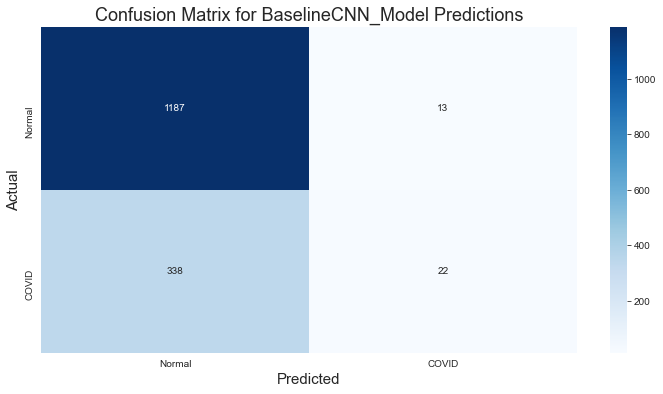

In [83]:
predictions = get_labels(cnn, X_test, 0.5)
plot_cmatrix('BaselineCNN_Model',y_test, predictions)

This model dominantly predicted all the images as Normal Images.

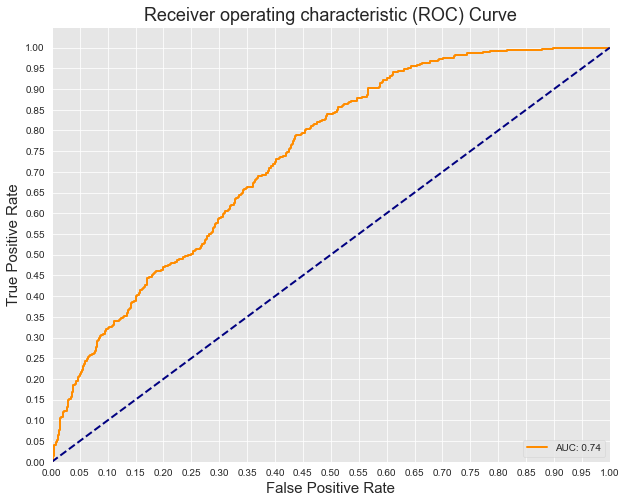

In [74]:
plot_roc_curve('BaselineCNN_Model',y_test, cnn.predict(X_test))

### 2.2 Densley Connected Network

In [84]:
train_folder = os.path.join(data_dir, 'train')
test_folder = os.path.join(data_dir, 'test')
val_folder = os.path.join(data_dir, 'validation')

In [23]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [24]:
# get all the data in the directory split/test, and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(200, 200), batch_size = 1560) 

# get all the data in the directory split/validation, and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(200, 200), batch_size = 1560)

# get all the data in the directory split/train, and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(200, 200), batch_size=12263)

Found 1560 images belonging to 2 classes.
Found 1560 images belonging to 2 classes.
Found 12263 images belonging to 2 classes.


In [25]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [71]:
cnn.predict(X_test)

array([[0.02710274],
       [0.0659002 ],
       [0.12245614],
       ...,
       [0.17849089],
       [0.5008322 ],
       [0.1760373 ]], dtype=float32)

In [26]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 12263
Number of testing samples: 1560
Number of validation samples: 1560
train_images shape: (12263, 200, 200, 3)
train_labels shape: (12263, 2)
test_images shape: (1560, 200, 200, 3)
test_labels shape: (1560, 2)
val_images shape: (1560, 200, 200, 3)
val_labels shape: (1560, 2)


In [27]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(12263, 120000)
(1560, 120000)
(1560, 120000)


In [28]:
train_y = np.reshape(train_labels[:,0], (12263,1))
test_y = np.reshape(test_labels[:,0], (1560,1))
val_y = np.reshape(val_labels[:,0], (1560,1))

In [29]:
np.random.seed(123)
dense_connected = models.Sequential()
dense_connected.add(layers.Dense(20, activation='relu', input_shape=(120000,))) # 2 hidden layers
dense_connected.add(layers.Dense(7, activation='relu'))
dense_connected.add(layers.Dense(5, activation='relu'))
dense_connected.add(layers.Dense(1, activation='sigmoid'))

In [30]:
dense_connected.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

dense_connected1 = dense_connected.fit(train_img,
                    train_y,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/50
384/384 [==============================] - 9s 22ms/step - loss: 0.6294 - accuracy: 0.7532 - val_loss: 0.6959 - val_accuracy: 0.2436
Epoch 2/50
384/384 [==============================] - 6s 14ms/step - loss: 0.4788 - accuracy: 0.7247 - val_loss: 0.5331 - val_accuracy: 0.7596
Epoch 3/50
384/384 [==============================] - 5s 14ms/step - loss: 0.4171 - accuracy: 0.8032 - val_loss: 0.5063 - val_accuracy: 0.7179
Epoch 4/50
384/384 [==============================] - 5s 14ms/step - loss: 0.4049 - accuracy: 0.8079 - val_loss: 0.5094 - val_accuracy: 0.6647
Epoch 5/50
384/384 [==============================] - 5s 14ms/step - loss: 0.4077 - accuracy: 0.8156 - val_loss: 0.5021 - val_accuracy: 0.7622
Epoch 6/50
384/384 [==============================] - 5s 14ms/step - loss: 0.3918 - accuracy: 0.8227 - val_loss: 0.5979 - val_accuracy: 0.7724
Epoch 7/50
384/384 [==============================] - 6s 15ms/step - loss: 0.3852 - accuracy: 0.8260 - val_loss: 0.5697 - val_accuracy: 0.7718

In [31]:
results_train = dense_connected.evaluate(train_img, train_y)

384/384 [==============================] - 5s 13ms/step - loss: 0.3088 - accuracy: 0.8649


In [32]:
results_test = dense_connected.evaluate(test_img, test_y)

49/49 [==============================] - 0s 5ms/step - loss: 0.4159 - accuracy: 0.8026


In [33]:
results_train

[0.30884838104248047, 0.8648781180381775]

In [34]:
results_test

[0.4159140884876251, 0.8025640845298767]

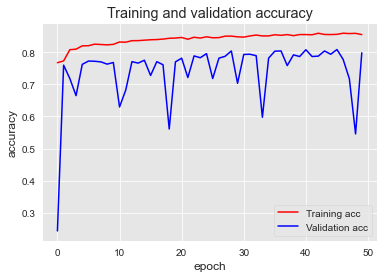

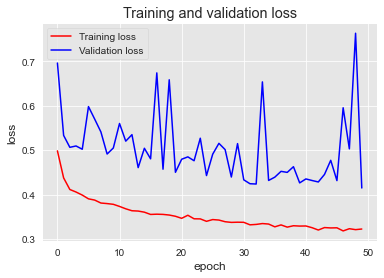

In [35]:
#Graphing our training and validation
acc = dense_connected1.history['accuracy']
val_acc = dense_connected1.history['val_accuracy']
loss = dense_connected1.history['loss']
val_loss = dense_connected1.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.savefig(f"./images/dense_connected_acc_loss.png" ,bbox_inches='tight')
plt.show()

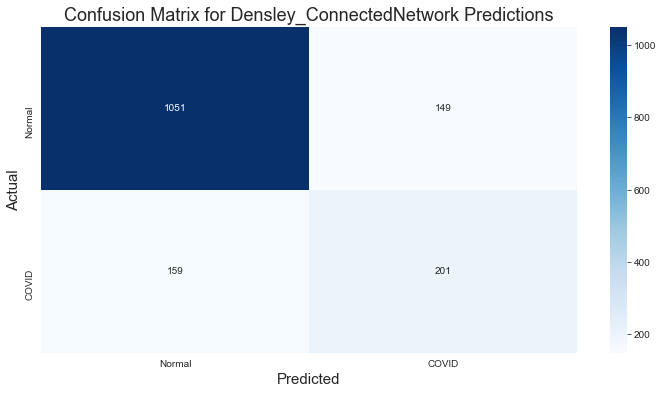

In [86]:
dense_pred = get_labels(dense_connected, test_img, 0.5)
plot_cmatrix('Densley_ConnectedNetwork', test_y, dense_pred)

Result looks a lot better than previous CNN model.

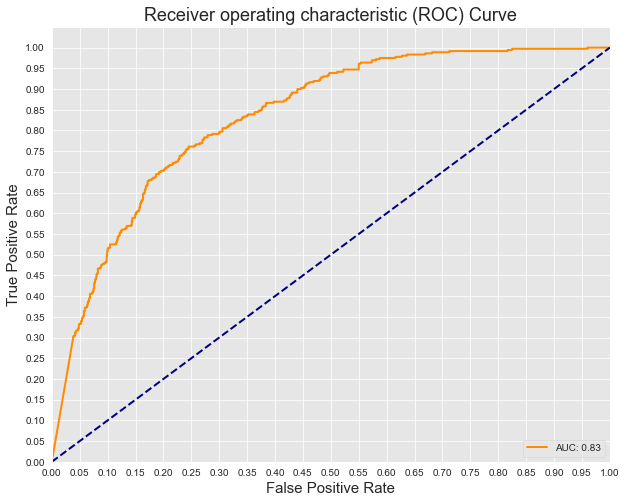

In [81]:
plot_roc_curve('Densely_Connected_Network_Model',test_y, dense_connected.predict(test_img))

### 2.3 Weighted CNN Model

In [92]:
# calculate inverse frequency
covid_frequency = sum(y_train)/len(y_train)
inv_covid_frequency = 1/covid_frequency
normal_frequency = (len(y_train)-sum(y_train))/len(y_train)
inv_normal_frequency = 1/normal_frequency
weights = {
    0: inv_normal_frequency,
    1: inv_covid_frequency
    }

In [93]:
#weighted model- put more weight on COVID from baseline model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

rms = tf.keras.optimizers.RMSprop(learning_rate=0.1)

cnn2 = models.Sequential()

# Input convolution layer
cnn2.add(layers.Conv2D(64, kernel_size= (3, 3), activation='relu', input_shape=(64, 64,  3)))

# Max pooling layer
cnn2.add(layers.MaxPooling2D((2, 2)))

# Hidden convolution layer and pool
cnn2.add(layers.Conv2D(32, kernel_size= (3, 3), activation='relu'))
cnn2.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
cnn2.add(layers.Flatten())
cnn2.add(layers.Dense(32, activation='relu'))

# Output
cnn2.add(layers.Dense(1, activation='sigmoid'))

# Compiling with stochastic gradient descent, optimized for accuracy
cnn2.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [ ]:
# Fitting the model with our additional class weight parameter
cnn3 = cnn2.fit(X_train, y_train,
               epochs=20,
               batch_size=50,
               validation_data = (X_val, y_val), 
               class_weight=weights,
               verbose=True,
               callbacks = callback)

Epoch 1/20
245/246 [============================>.] - ETA: 0s - loss: 1.3268 - acc: 0.5616

In [ ]:
results_test = cnn2.evaluate(X_test, y_test)

In [ ]:
#Graphing our training and validation
acc = dense_connected1.history['acc']
val_acc = dense_connected1.history['val_acc']
loss = dense_connected1.history['loss']
val_loss = dense_connected1.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.savefig(f"./images/Weighted_CNN_acc_loss.png" ,bbox_inches='tight')
plt.show()

In [ ]:
predictions = get_labels(cnn2, X_test, 0.5)
plot_cmatrix('Weighted_CNN',y_test, predictions)

Prediction is great! It shows 0.87 Accuracy

In [ ]:
plot_roc_curve('Weighted_CNN',y_test, cnn2.predict(X_test))

In [ ]:
final_model_report = classification_report(y_test, predictions)

print(final_model_report)

adj_false_positive = 185/1200*360
adj_precision = 342/(342+adj_false_positive)
adj_precision

Adjust Precision becomes 0.86

## 3. Conclusion

1. We chose weighted CNN model because this model detect COVID-19 well and also detect normal well.

2. Our weighted CNN model can be useful as a method of COVID-19 detection for hospitals when they don’t have test kit.

## 4. Ideas for Improvement

1. See if the model can differentiate COVID X-ray images from other lung disease X-ray images such as pneumonia.
2. See if we can develop other models to detect other diseases using X-ray images.